In [1]:
import csv
import ast
import re
import numpy as np
import pandas as pd
import seaborn as sns

from Bio import SeqIO

from matplotlib import pyplot as plt

In [2]:
def cigarsfromsam(samfilepath):
    cigars = {}
    with open(samfilepath,"r") as samfile:
        for line in samfile:
            if line[0]=="@":
                next(samfile)
            else:
                splitline = line.split("\t")
                cigars[splitline[0]] = splitline[5]
    return cigars

def strsfromfasta(fastafilepath):
    queries = SeqIO.to_dict(SeqIO.parse(fastafilepath,"fasta"))
    queries = {key: str(val.seq) for key,val in queries.items()}
    return queries

def make_seg_dict(gfafile):
    segment_dict = {}
    with open(gfafile,"r") as infile:
        for line in infile:
            if line[0] == "S":
                splitline = line.split("\t")
                segment_dict[splitline[1]] = splitline[2][:-1]
    return segment_dict

def get_ref_intervals(gfafile):
    segment_dict = {}
    current_idx = 0
    with open(gfafile,"r") as infile:
        for line in infile:
            if line[0] == "S":
                splitline = line.split("\t")
                if "OFF" not in splitline[1]:
                    refstr = splitline[2][:-1]
                    strlen = len(refstr)
                    name = splitline[1]
                    if "ON" in name:
                        name=name[:-2]
                    segment_dict[name] = tuple((current_idx,current_idx+strlen))
                    current_idx += strlen
    return segment_dict
    
def align_read(querystr,cigarstr,pattern=re.compile("[0-9]{0,10}[MX=DI]")):
    result = pattern.finditer(cigarstr)
    cigar_seq = [(item.group(0)[-1],int(item.group(0)[:-1])) for item in result]
#     output_str = "".join(["-" for i in range(cigar[1])])
    output_str = ""
    current_idx = 0
    for item in cigar_seq:
        if any([item[0] == "M",item[0] == "=",item[0] == "X"]):
            added_str = querystr[current_idx:current_idx+item[1]]
            output_str += added_str
            current_idx += item[1]
        elif item[0]=="D":
            added_str = "".join(["-" for i in range(item[1])])
            output_str += added_str
        elif item[0]=="I":
            current_idx += item[1]
    return output_str

def align_read_sanger(querystr, refstr, cigarstr, startpos=1, pattern=re.compile("[0-9]{0,10}[MX=DI]")):
    start_pos = startpos - 1  ##comes as 1 indexed from minimap
    result = pattern.finditer(cigarstr)
    cigar_seq = [(item.group(0)[-1], int(item.group(0)[:-1])) for item in result]
    output_str = ""
    if start_pos > 0:
        output_str += "".join(["-" for i in range(start_pos)])
    current_idx = 0
    for item in cigar_seq:
        if any([item[0] == "M",item[0] == "=",item[0] == "X"]):
            added_str = querystr[current_idx : current_idx + item[1]]
            output_str += added_str
            current_idx += item[1]
        elif item[0] == "D":
            added_str = "".join(["-" for i in range(item[1])])
            output_str += added_str
        elif item[0] == "I":
            current_idx += item[1]
    remaining_len = len(refstr) - len(output_str)
    if remaining_len > 0:
        output_str += "".join(["-" for i in range(remaining_len)])
    return output_str

def splitstr(instr,ref_intervals):    
    strassign = {key:instr[val[0]:val[1]] for key,val in ref_intervals.items()}
    return strassign

def slow_hamming_distance(s1, s2):
    if len(s1) != len(s2):
        print(s1,s2)
        raise ValueError("Strand lengths are not equal!")
    term_list = []
    for ch1,ch2 in zip(s1,s2):
        if ch1 == "N" or ch2 == "N":
            term_list.append(False)
        else:
            term_list.append(ch1 != ch2)
    result = sum(term_list)
    return result

def get_dict_dist(dict1,dict2):
    hamming_dict = {key:slow_hamming_distance(dict1[key],dict2[key]) for key in dict1.keys()}
    return hamming_dict

In [44]:
# Imports
R9_data = pd.read_csv("/home/de64/scratch/de64/sync_folder/2020-10-18_snakemake_2020-09-24_oDEPool3/output.tsv",delimiter="\t")
R10_data = pd.read_csv("/home/de64/scratch/de64/sync_folder/2020-10-18_snakemake_2020-10-14_lDE11_R10-3_merged/output.tsv",delimiter="\t")
R10_data_high_depth = pd.read_csv("/home/de64/scratch/de64/sync_folder/2020-10-20_snakemake_2020-10-14_lDE11_R10-3_merged_final/output.tsv",delimiter="\t")
ref_intervals = get_ref_intervals("/home/de64/scratch/de64/sync_folder/2020-10-18_snakemake_2020-10-14_lDE11_R10-3_merged/ref.gfa")

### Part 1: Get Sequencing Dataframes

In [45]:
R9_barcodes = set(R9_data["barcode"].tolist())
R10_barcodes = set(R10_data["barcode"].tolist())

R9_only_barcodes = R9_barcodes-R10_barcodes
R10_only_barcodes = R10_barcodes-R9_barcodes
shared_barcodes = R10_barcodes&R9_barcodes
barcode_count_arr = np.array([len(R9_only_barcodes),len(R10_only_barcodes),len(shared_barcodes)])

R9_data = R9_data[R9_data["barcode"].isin(shared_barcodes)]
R10_data = R10_data[R10_data["barcode"].isin(shared_barcodes)]

In [46]:
aligned_cons = R9_data.apply(lambda x: align_read(x["consensus"],x["cigar"]), axis=1)
R9_data["aligned_cons"] = aligned_cons

aligned_cons = R10_data.apply(lambda x: align_read(x["consensus"],x["cigar"]), axis=1)
R10_data["aligned_cons"] = aligned_cons

aligned_cons = R10_data_high_depth.apply(lambda x: align_read(x["consensus"],x["cigar"]), axis=1)
R10_data_high_depth["aligned_cons"] = aligned_cons

split_ref = R9_data.apply(lambda x: splitstr(x["reference"],ref_intervals), axis=1)
split_align = R9_data.apply(lambda x: splitstr(x["aligned_cons"],ref_intervals), axis=1)
R9_data["split_ref"] = split_ref
R9_data["split_align"] = split_align

split_ref = R10_data.apply(lambda x: splitstr(x["reference"],ref_intervals), axis=1)
split_align = R10_data.apply(lambda x: splitstr(x["aligned_cons"],ref_intervals), axis=1)
R10_data["split_ref"] = split_ref
R10_data["split_align"] = split_align

split_ref = R10_data_high_depth.apply(lambda x: splitstr(x["reference"],ref_intervals), axis=1)
split_align = R10_data_high_depth.apply(lambda x: splitstr(x["aligned_cons"],ref_intervals), axis=1)
R10_data_high_depth["split_ref"] = split_ref
R10_data_high_depth["split_align"] = split_align

R9_data["split_ref"] = R9_data["split_ref"].apply(lambda x: {key:val for key,val in x.items() if key=="GFP"}) ## This is a hack until I can repull the alignment data...then I'll add padding for the unaligned parts
R9_data["split_align"] = R9_data["split_align"].apply(lambda x: {key:val for key,val in x.items() if key=="GFP"}) ## This is a hack until I can repull the alignment data...

R10_data["split_ref"] = R10_data["split_ref"].apply(lambda x: {key:val for key,val in x.items() if key=="GFP"}) ## This is a hack until I can repull the alignment data...then I'll add padding for the unaligned parts
R10_data["split_align"] = R10_data["split_align"].apply(lambda x: {key:val for key,val in x.items() if key=="GFP"}) ## This is a hack until I can repull the alignment data...

R10_data_high_depth["split_ref"] = R10_data_high_depth["split_ref"].apply(lambda x: {key:val for key,val in x.items() if key=="GFP"}) ## This is a hack until I can repull the alignment data...then I'll add padding for the unaligned parts
R10_data_high_depth["split_align"] = R10_data_high_depth["split_align"].apply(lambda x: {key:val for key,val in x.items() if key=="GFP"}) ## This is a hack until I can repull the alignment data...

hamm_ref = R9_data.apply(lambda x: get_dict_dist(x["split_align"],x["split_ref"]), axis=1)
R9_data["hamm_ref"] = hamm_ref
hamm_ref = R10_data.apply(lambda x: get_dict_dist(x["split_align"],x["split_ref"]), axis=1)
R10_data["hamm_ref"] = hamm_ref
hamm_ref = R10_data_high_depth.apply(lambda x: get_dict_dist(x["split_align"],x["split_ref"]), axis=1)
R10_data_high_depth["hamm_ref"] = hamm_ref

dark_gfp = R9_data.apply(lambda x: slow_hamming_distance(x["split_align"]["GFP"][623:625],x["split_ref"]["GFP"][623:625]), axis=1)>0
R9_data["dark_gfp"] = dark_gfp
dark_gfp = R10_data.apply(lambda x: slow_hamming_distance(x["split_align"]["GFP"][623:625],x["split_ref"]["GFP"][623:625]), axis=1)>0
R10_data["dark_gfp"] = dark_gfp
dark_gfp = R10_data_high_depth.apply(lambda x: slow_hamming_distance(x["split_align"]["GFP"][623:625],x["split_ref"]["GFP"][623:625]), axis=1)>0
R10_data_high_depth["dark_gfp"] = dark_gfp

R9_data["UMI"] = R9_data["split_align"].apply(lambda x: x["GFP"][925:940])
R10_data["UMI"] = R10_data["split_align"].apply(lambda x: x["GFP"][925:940])
R10_data_high_depth["UMI"] = R10_data_high_depth["split_align"].apply(lambda x: x["GFP"][925:940])

R9_data.to_csv("./lDE11_R9_df.tsv", sep="\t")
R10_data.to_csv("./lDE11_R10_df.tsv", sep="\t")
R10_data_high_depth.to_csv("./lDE11_R10_All_Samples_df.tsv", sep="\t")

TypeError: align_read() missing 1 required positional argument: 'cigarstr'

### Part 2: Get Call Rates

In [30]:
R9_data = pd.read_csv("./lDE11_R9_df.tsv", sep="\t")
R10_data = pd.read_csv("./lDE11_R10_df.tsv", sep="\t")

In [31]:
## compute calls
R9_ground_truth_data = R9_data[R9_data["subsample"]==200]
R9_ground_truth_lookup = dict(zip(R9_ground_truth_data["barcodeid"],R9_ground_truth_data["dark_gfp"]))

R9_data["GFP Call"] = R9_data.apply(lambda x: x["dark_gfp"]==R9_ground_truth_lookup[x["barcodeid"]],axis=1)

R10_ground_truth_data = R10_data[R10_data["subsample"]==200]
R10_ground_truth_lookup = dict(zip(R10_ground_truth_data["barcodeid"],R10_ground_truth_data["dark_gfp"]))

R10_data["GFP Call"] = R10_data.apply(lambda x: x["dark_gfp"]==R10_ground_truth_lookup[x["barcodeid"]],axis=1)

R9_subsample_group = R9_data.groupby("subsample")
R10_subsample_group = R10_data.groupby("subsample")

R9_GFP_call_curve = 1-R9_subsample_group.aggregate({'GFP Call': 'mean'})
R10_GFP_call_curve = 1-R10_subsample_group.aggregate({'GFP Call': 'mean'})

R9_GFP_q_scores = -10*np.log10(R9_GFP_call_curve)
R10_GFP_q_scores = -10*np.log10(R10_GFP_call_curve)

/home/de64/micromamba/envs/nanopore/lib/python3.10/site-packages/pandas/core/internals/blocks.py:366: RuntimeWarning: divide by zero encountered in log10
  result = func(self.values, **kwargs)


### UMI Error

In [32]:
R9_ground_truth_umi_lookup = dict(zip(R9_ground_truth_data["barcodeid"],R9_ground_truth_data["UMI"]))
R9_data["UMI Errors"] = R9_data.apply(lambda x: slow_hamming_distance(x["UMI"],R9_ground_truth_umi_lookup[x["barcodeid"]]),axis=1)
R9_data["UMI Error Rate"] = R9_data["UMI Errors"]/15
R9_subsample_group = R9_data.groupby("subsample")
R9_UMI_call_curve = R9_subsample_group.aggregate({'UMI Error Rate': 'mean'})

R10_ground_truth_umi_lookup = dict(zip(R10_ground_truth_data["barcodeid"],R10_ground_truth_data["UMI"]))
R10_data["UMI Errors"] = R10_data.apply(lambda x: slow_hamming_distance(x["UMI"],R10_ground_truth_umi_lookup[x["barcodeid"]]),axis=1)
R10_data["UMI Error Rate"] = R10_data["UMI Errors"]/15
R10_subsample_group = R10_data.groupby("subsample")
R10_UMI_call_curve = R10_subsample_group.aggregate({'UMI Error Rate': 'mean'})

In [33]:
R9_GFP_call_curve

,GFP Call
subsample,
5,0.037131
10,0.012940
15,0.006188
20,0.004219
25,0.005626
50,0.001688
200,0.000000


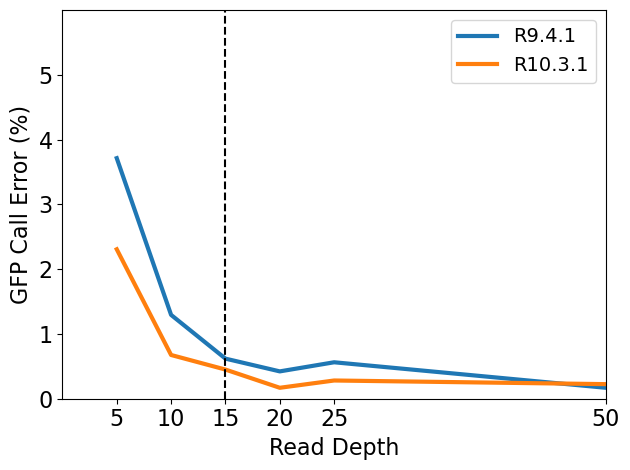

In [158]:
plt.plot(R9_GFP_call_curve*100,linewidth=3.,label="R9.4.1")
plt.plot(R10_GFP_call_curve*100,linewidth=3.,label="R10.3.1")
plt.axvline(15,color="C1",ls="--",c="black")
plt.ylim(0.,6.)
plt.xlim(0,50)
plt.xticks([5,10,15,20,25,50],fontsize=16)
plt.yticks([0.,1.,2.,3.,4.,5.],fontsize=16)
plt.xlabel("Read Depth",fontsize=16)
plt.ylabel("GFP Call Error (%)",fontsize=16)
plt.legend(fontsize=14)
plt.tight_layout()
plt.savefig("/home/de64/group/de64/nanopore/dev_notebooks/2024-01-07_lDE11_Sequencing_Analysis_Final/Figure_S1_1.png",dpi=300)

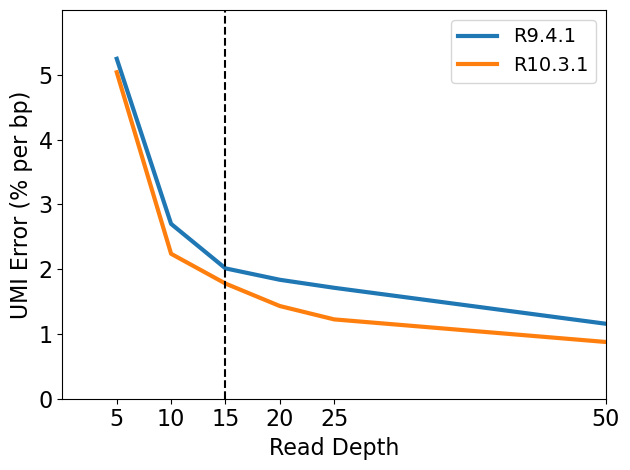

In [160]:
plt.plot(R9_UMI_call_curve*100,linewidth=3.,label="R9.4.1")
plt.plot(R10_UMI_call_curve*100,linewidth=3.,label="R10.3.1")
plt.axvline(15,color="C1",ls="--",c="black")
plt.ylim(0.,6.)
plt.xlim(0,50)
plt.xticks([5,10,15,20,25,50],fontsize=16)
plt.yticks([0.,1.,2.,3.,4.,5.],fontsize=16)
plt.xlabel("Read Depth",fontsize=16)
plt.ylabel("UMI Error (% per bp)",fontsize=16)
plt.legend(fontsize=14)
plt.tight_layout()
plt.savefig("/home/de64/group/de64/nanopore/dev_notebooks/2024-01-07_lDE11_Sequencing_Analysis_Final/Figure_S1_2.png",dpi=300)

### Part 3: Sanger Error

#### Convert to fastq and group

In [ ]:
with open("./ab1_files/merged.fastq", "w") as outfile:
    for i in range(1, 97):
        filepath1 = "./ab1_files/lDE11_validation_sample_" + str(i) + "-oDE154.ab1"
        filepath2 = "./ab1_files/lDE11_validation_sample_" + str(i) + "-oDE201.ab1"

        record1 = SeqIO.read(filepath1, "abi")
        record2 = SeqIO.read(filepath2, "abi")

        SeqIO.write(record1, outfile, "fastq")
        SeqIO.write(record2, outfile, "fastq")

#### Align to GAF

In [59]:
!GraphAligner -g ./ref.gfa -f ./ab1_files/merged.fastq -a ./ab1_files/aligned.gaf -x dbg -b 20 -C 1000

GraphAligner bioconda 1.0.17-
GraphAligner bioconda 1.0.17-
Load graph from ./ref.gfa
Build alignment graph
Build minimizer seeder from the graph
Minimizer seeds, length 19, window size 30, density 5
Seed cluster size 1
Extend up to 5 seed clusters
Alignment bandwidth 20, tangle effort 1000
Clip alignment ends with identity < 66%
X-drop DP score cutoff 14705
Backtrace from 10 highest scoring local maxima per cluster
write alignments to ./ab1_files/aligned.gaf
Align
Alignment finished
Input reads: 192 (193156bp)
Seeds found: 15017
Seeds extended: 192
Reads with a seed: 192 (193156bp)
Reads with an alignment: 192 (193138bp)
Alignments: 192 (193138bp)
End-to-end alignments: 186 (186924bp)


#### Get cigar strings, barcodes and read sequences for each isolate

In [98]:
cigar_dict = {}
with open("./ab1_files/aligned.gaf", "r") as infile:
    for line in infile:
        data = line.split("\t")
        read_id = data[0].split(" ")[0]
        if ">" in data[5]:
            cigar_dict[read_id] = (
                "+",
                int(data[7]),
                int(data[8]),
                data[5],
                data[16].split(":")[-1][:-1],
            )
        else:
            cigar_dict[read_id] = (
                "-",
                int(data[7]),
                int(data[8]),
                data[5],
                data[16].split(":")[-1][:-1],
            )

barcode_dict = {}
for key in cigar_dict.keys():
    cigar = cigar_dict[key]
    if "oDE201" in key:
        barcode = cigar[3].split("<")
        barcode = barcode[::-1]
        barcode = barcode[:-1]
        barcode = (
            np.array(["ON" in item for item in barcode if "BIT" in item])
            .astype(int)
            .astype(str)
            .tolist()
        )
        barcode = "".join(barcode)
        index = key.split("_")[3].split("-")[0]
        barcode_dict[int(index)] = barcode

with open("./ab1_files/merged.fastq", "r") as infile:
    read_dict = SeqIO.parse(infile, "fastq")
    read_dict = SeqIO.to_dict(read_dict)
    read_dict = {key:str(val.seq) for key,val in read_dict.items()}

#### Get agreement between reads and nanopore calls at GFP/DarkGFP site

In [139]:
R10_data_high_depth = pd.read_csv("./lDE11_R10_All_Samples_df.tsv", sep="\t")

R10_data_high_depth_output_rows = []
for i in range(1, 97):
    if np.sum(R10_data_high_depth["barcode"] == barcode_dict[i]) == 1:
        output_row = R10_data_high_depth[R10_data_high_depth["barcode"] == barcode_dict[i]].copy()
        gfp_read_name = "lDE11_validation_sample_" + str(i) + "-oDE154"
        aligned = align_read_sanger(
            read_dict[gfp_read_name],
            R10_data_high_depth[R10_data_high_depth["barcode"] == barcode_dict[i]]["reference"].iloc[0],
            cigar_dict[gfp_read_name][4],
            startpos=cigar_dict[gfp_read_name][1] + 1,
        )
        ref_intervals = get_ref_intervals("./ref.gfa")
        split_ref = splitstr(
            R10_data_high_depth[R10_data_high_depth["barcode"] == barcode_dict[i]]["reference"].iloc[0],
            ref_intervals,
        )
        split_consensus = splitstr(
            R10_data_high_depth[R10_data_high_depth["barcode"] == barcode_dict[i]]["consensus"].iloc[0],
            ref_intervals,
        )
        split_align = splitstr(aligned, ref_intervals)
        snp_hamming = slow_hamming_distance(
            split_align["GFP"][623:625], split_consensus["GFP"][623:625]
        )        
        R10_data_high_depth_output_rows.append(output_row)
R10_data_high_depth_sanger = pd.concat(R10_data_high_depth_output_rows,axis=0).sort_index()
sanger_err_rate = np.sum(R10_data_high_depth_sanger["Sanger GFP Hamming"]>0)/len(R10_data_high_depth_sanger)

In [149]:
sanger_err_rate

0.010752688172043012

### Part 4: Read Depth Distributions (lDE15 and lDE20)